In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
NUMOFPARAMS = 10
OrderOfColumnsForTraining = ['lddt','fident', 'bits', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen',
       'alntmscore', "FracOfPf","p_evalue", 'query', 'target','qstart',
       'qend', 'tstart', 'tend', 'qlen','PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status']

#It assumes all the parameters used for the training are located in the first columns of the X

In [4]:
from numpy import log
    
def PreprocessingLabeledData(df):
    """This is for calculating the pfam coverage, and replacing 0 e-values, it will also change
    the order of the columns. Before running this, the input must have been labeled. """
    df["FracOfPf"] = (df["tend"] -df["tstart"] + 1)/df["tlen"]
    df["p_evalue"] = -log(df["evalue"] + 1e-300)
    df["MismatchRatio"] = df["mismatch"]/df['alnlen'] *100
    df["GapOpenRatio"] = df["gapopen"]/df['alnlen'] *100
    df = df[OrderOfColumnsForTraining] #This is for putting the parameters
    # to learn from in the beginning, and for selecting the needed columns
    return df

In [5]:
%matplotlib inline

In [6]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates/*/*e3_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [7]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)

LabeledData_tb = TbData[TbData["Status"]!=-1]
#I shuffle all the samples at this stage
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

X_tb_labeled = LabeledData_tb[OrderOfColumnsForTraining].values # The alignments of Tb will have a distinct naming convention
y_tb_labeled = LabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention

del LabeledData_tb

UnLabeledData_tb = TbData[TbData["Status"]==-1]
X_tb_unlabeled = UnLabeledData_tb[OrderOfColumnsForTraining].values # The alignments of Tb will have a distinct naming convention
y_tb_unlabeled = UnLabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention
del UnLabeledData_tb
del TbData


In [8]:
totalNumAli = X_tb_labeled.shape[0] + X_tb_unlabeled.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(y_tb_labeled[y_tb_labeled[:]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(y_tb_labeled[y_tb_labeled[:]==0].shape[0]*100/totalNumAli))


There are a total of 1042967 possible alignments between Proteome of interest and Pfam instances
39.3260764722182 percent of the data is labeled as 1 
35.37954700388411 percent of the data is labeled as 0 


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_tb_labeled, y_tb_labeled, train_size = 0.6, test_size=0.4, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size=0.5, shuffle=False)

In [10]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:NUMOFPARAMS], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
#import joblib
#joblib.dump(rf, "./PFAS_RF.joblib", compress=3)

In [11]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:NUMOFPARAMS], y_train_frac)
    ModelDict[train_size] = rf
del X_train_frac, X_test_frac, y_train_frac, y_test_frac

In [12]:
X_dict_orgs = {}
y_dict_orgs = {}

for org in DictOfAdds:
    if org == "Tb":
        continue 
    Data = pd.read_csv(DictOfAdds[org], sep="\t")
    Data = PreprocessingLabeledData(Data)
    print("The summary of the alignments for {}".format(org))
    print("There are total of {} possible alignments between Proteome of {} and Pfam instances".format(Data.shape[0], org))
    totalNum = Data.shape[0]
    print("{} percent of the data is labeled 1 ".format(Data[Data["Status"]==1].shape[0]/totalNum*100))
    print("{} percent of the data is labeled 0 ".format(Data[Data["Status"]==0].shape[0]/totalNum*100))
    Data = Data[Data["Status"]!=-1]
    X_dict_orgs[org] = Data[OrderOfColumnsForTraining].values
    y_dict_orgs[org] = Data['Status'].values
    del Data

The summary of the alignments for Ec
There are total of 1314886 possible alignments between Proteome of Ec and Pfam instances
47.30843586440193 percent of the data is labeled 1 
50.95392300168988 percent of the data is labeled 0 
The summary of the alignments for Mj
There are total of 449385 possible alignments between Proteome of Mj and Pfam instances
41.85319937247572 percent of the data is labeled 1 
52.68288883696608 percent of the data is labeled 0 
The summary of the alignments for Sc
There are total of 1131612 possible alignments between Proteome of Sc and Pfam instances
43.92282867272528 percent of the data is labeled 1 
42.395891878134904 percent of the data is labeled 0 


In [13]:
def PrepareDataForAUCplot(model, X):
    PFindex = OrderOfColumnsForTraining.index("PF")
    PF = X[:, PFindex]
    y_pred_prob = model.predict_proba(X[:,:NUMOFPARAMS])[:, 1]
    LabelsIndex = OrderOfColumnsForTraining.index("Status")
    Labels = X[:, LabelsIndex]
    Summary = pd.DataFrame({"Label": Labels, "PF":PF, "PredProb": y_pred_prob})
    return Summary  

In [14]:
def Input4AUCplot(AlnDF, ExcPFList):
    PlotDF = AlnDF[~AlnDF["PF"].isin(ExcPFList)]
    fpr, tpr, _ = metrics.roc_curve(PlotDF["Label"].astype(int), PlotDF["PredProb"])
    auc = round(metrics.roc_auc_score(PlotDF["Label"].astype(int), PlotDF["PredProb"]),3)
    return fpr,tpr,auc    

In [15]:
def PlotAUC(PlotParams,org, labels):
    if len(labels)==0:
        plt.plot(PlotParams[0],PlotParams[1],label= "$\it{" + FullNameDict[org] +"}$, AUC="+str(PlotParams[2]))
    else:
        plt.plot(PlotParams[0],PlotParams[1],label= "$\it{" + FullNameDict[org] +"}$, " + ", ".join(labels) +", AUC="+str(PlotParams[2]))
    

In [16]:
PFindex = OrderOfColumnsForTraining.index("PF") #Finding the PFs in the training set
TrainingPFs = np.unique(X_train[:,PFindex])

<Figure size 640x480 with 0 Axes>

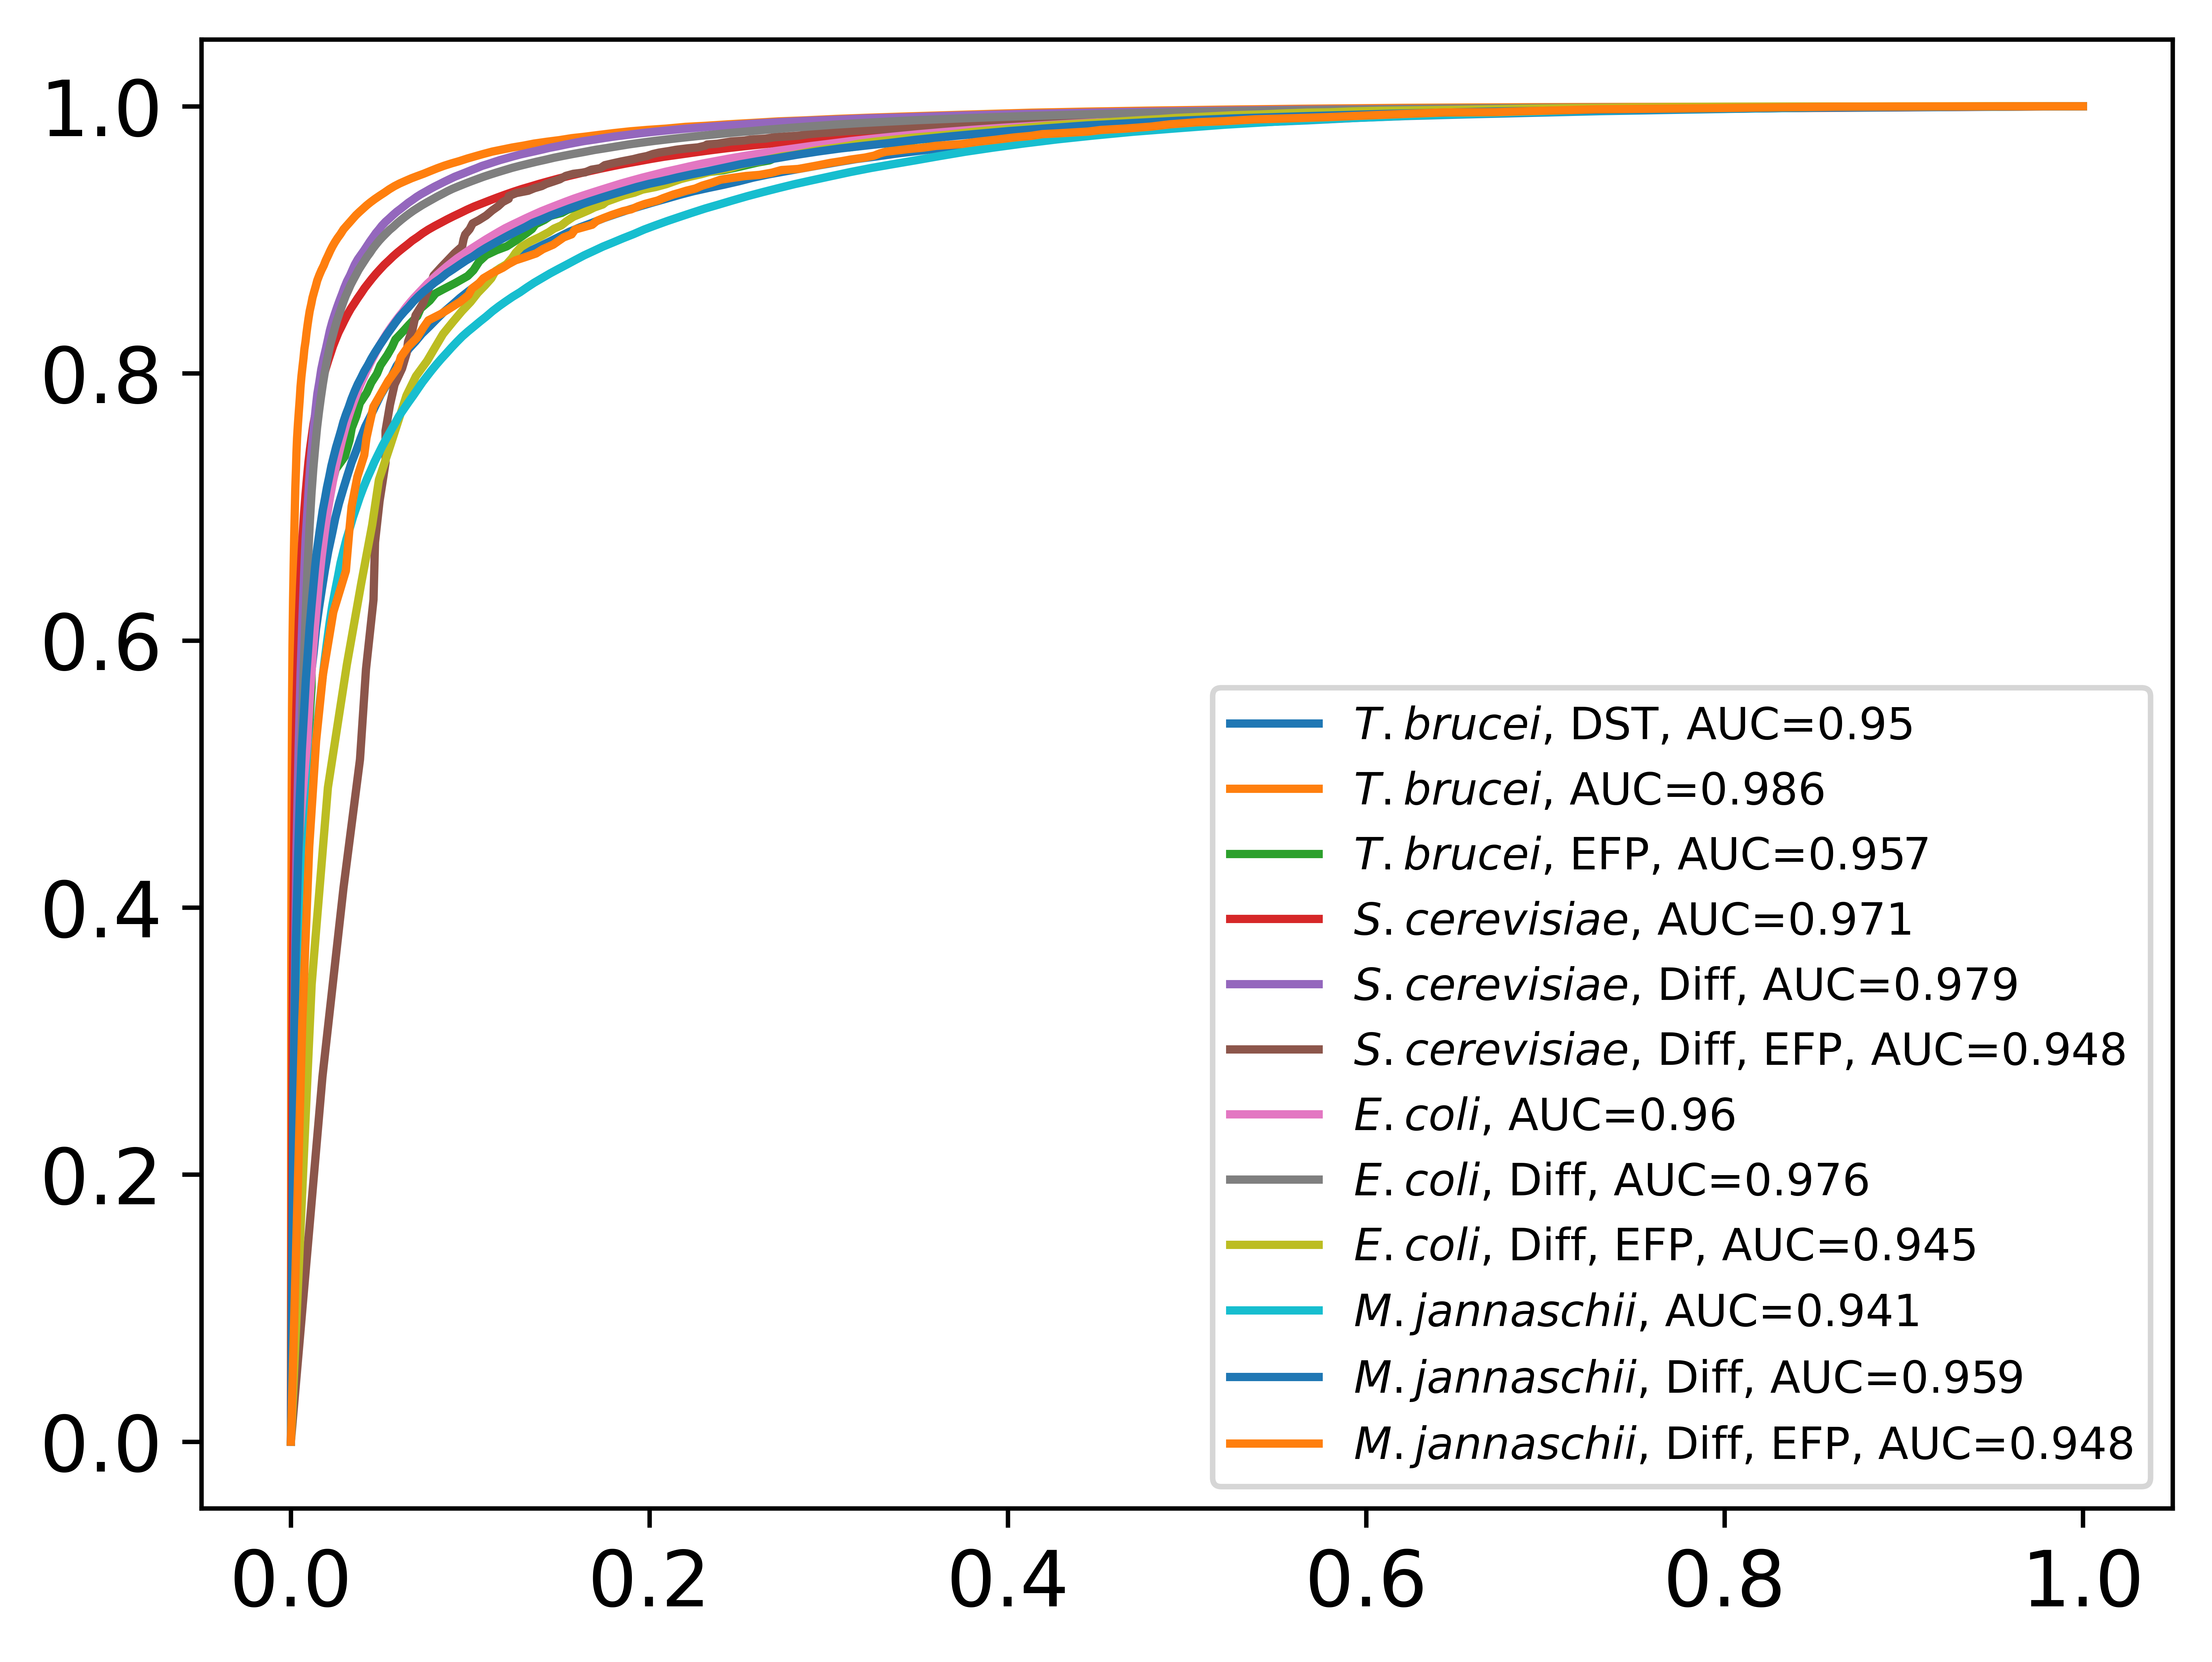

In [17]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Pars = Input4AUCplot(PrepareDataForAUCplot( ModelDict[0.01], X_test), [])
PlotAUC(Pars, "Tb", ["DST"])

for org in ["Tb", "Sc", "Ec", "Mj"]:
    if org=="Tb":
        X_ = X_test
    else:
        X_ = X_dict_orgs[org] 
    tags = []
    AlnSummary = PrepareDataForAUCplot(ModelDict[1], X_)
    Params = Input4AUCplot(AlnSummary,[] )
    PlotAUC(Params,org, tags)
    if org!= "Tb":
        AlnSummary = AlnSummary[~AlnSummary["PF"].isin(TrainingPFs)]
        tags = ["Diff"]  #The diff tag is for showing that AUC has been calculated on proteins with Pfams different than the training PFs
        #Params = Input4AUCplot(AlnSummary,[] )
        PlotAUC(Input4AUCplot(AlnSummary,[] ),org, tags)
    GroupedByPF = AlnSummary.groupby("PF").size()
    Threshold = int(GroupedByPF.quantile(0.5))
    HighFreqs = GroupedByPF[GroupedByPF>Threshold].index
    tags += ["EFP"] #EFP stands for excluding frequent pfams. I find the number of times each Pfam had been observed in the queries, and exclude those whose frequency was above the median of frequency
    PlotAUC(Input4AUCplot(AlnSummary,HighFreqs ),org, tags)
    
    #excluding frequents
    #excluding Tb
    
plt.legend(prop={'size': 8})
#plt.legend(bbox_to_anchor=(1.55, 0.3))
#Pars = Input4AUCplot(PrepareDataForAUCplot( ModelDict[1], X_test), [])
#PlotAUC(Pars, "Tb", [])

In [1]:
#In this cell, functions for performance evaluation have been defined.

#def CalcAUC(df):
#    return metrics.roc_auc_score(df["Label"], df["PredProb"])

#def CalcAccuracy(df):
#    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
#    SampleSize = df.shape[0]
#    accuracy = CorrectNums/SampleSize
#    return accuracy

#def CalAUCgroupwise(df):
#    return df.apply(lambda x: CalcAUC(x)).mean()

#def MeanAccGroupedWise(df):
#    return df.apply(lambda x: CalcAccuracy(x)).mean()
    
#from scipy.stats import binom
#def CalcPval(df, ACC):
#    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
#    SampleSize = df.shape[0]
#    p_value = binom.cdf(CorrectNums,SampleSize,ACC)
#    return p_value

# Best hit attribution benchmarking
The next part is for Evaluating Best Hit attribution, first, we have to predict the probability and the label of each alignment by the trained model, then select the best hit, and continue annotating new domain to the point each newly added domain overlaps less than 10 aminoacids with previously added domains.

In [39]:
OrderOfColumnsForReportingDomains = ['query','PredPF','qstart', 'qend',"RF_prob", "target", "tstart", "tend",  
        'lddt', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
        'alntmscore', "FracOfPf","p_evalue", 'PF',"Status"]

In [40]:
def AddingPredProbAndLabel2DF(X, model):
    """This is for adding the predictions and the confidence score to each alignment record"""
    PredProb  = model.predict_proba(X[:,:NUMOFPARAMS])[:, 1]
    PredLabel = model.predict(X[:,:NUMOFPARAMS])
    df = pd.DataFrame(data = X, columns = OrderOfColumnsForTraining)
    df["PredLabel"] = PredLabel
    df["RF_prob"] = PredProb
    df = df[df["PredLabel"]==1]
    df.sort_values(by=["query", "RF_prob"], ascending=[True, False], ignore_index = True, inplace=True)
    df = df[OrderOfColumnsForReportingDomains]
    return df

In [41]:
def OverLapReturner(Interval1, Interval2):
    """It takes two intervals as input and returns the overlap between them as output"""
    MaxStart = max(Interval1[0], Interval2[0])
    MinEnd  =  min(Interval1[1], Interval2[1])
    return max(MinEnd-MaxStart+1,0)

In [42]:
def SelectingBestNonOverlappingHits(df,PF_Anns = {}):
    """This function takes the dataframe containing all preprocessed alignments as input, and reports 
    the highest scoring non-overlapping alignments on each target protein. Optionally, you can specify 
    the current Pfam annotations of the proteins in a dictionary whose keys are gene names, and values
    are tuples of the intervals of the pfams"""
    ListOfRows = []
    OverlapThreshold = 10
    for (i, CurID,start, end)  in zip(df.index, df["query"], df['qstart'],df['qend']):
        row = df.loc[i,:]
        ListOfIntervals = PF_Anns.get(CurID, [])
        SignificantOverLap = False
        for Interval in ListOfIntervals:
            if OverLapReturner(Interval, (start,end)) >= OverlapThreshold:
                SignificantOverLap = True
                break
        if (SignificantOverLap==False):
            ListOfRows.append(row)
            ListOfIntervals.append((start,end))
            PF_Anns[CurID] = ListOfIntervals
    OutDF = pd.DataFrame(data= ListOfRows, columns = df.columns)
    return OutDF

In [43]:
#This block is for retrieving the number of annotated Pfams for each organism
PfamAnnotationNums = {}
for org in FullNameDict.keys():
    file = open("../rawinput/{}/Pfam{}.txt".format(org,org))
    NumOfAnnotations = len(file.read().strip().split("\n"))
    PfamAnnotationNums[org] = NumOfAnnotations
    

The next block is for retrieving the Proteins in each organism among the Pfam Seeds


In [44]:
PfamSeedsDict = {}
for org in FullNameDict.keys():
    PfamSeedsInOrg = open("../rawinput/{}/PfamSeeds{}.tsv".format(org,org)).read().strip().split("\n")
    PfamSeedsDict[org] = PfamSeedsInOrg

In [45]:
def Precision(df):
    TotalPreds = df.shape[0]
    CorrectPreds = df[df["Status"]==1].shape[0]
    return CorrectPreds/TotalPreds
def Sensitivity(df, org):
    correctAnns = df[df["Status"]==1]
    return correctAnns.shape[0]/PfamAnnotationNums[org]

In [46]:
model = ModelDict[1]
PrecisionDict = {}
AnnotDict = {}

AnnotDFTb = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_tb_labeled, model))
AnnotDict["Tb"] = AnnotDFTb


In [47]:
for org in X_dict_orgs.keys():
    AnnotDF = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_dict_orgs[org], model))
    AnnotDict[org] = AnnotDF

In [48]:
for org in AnnotDict.keys():
    annots = AnnotDict[org]
    TruePreds = annots[annots["Status"]==1] 
    print("information on {}".format(org))
    print("{} percent of Annotated Pfams have been correctly annotated".format(100* Precision(annots)))
    print("{} percent of Annotated Pfams have been retrieved correctly".format(100* Sensitivity(annots, org)))
    print("When considering those not among the Pfam Seeds:")
    NotSeedsDF = annots[~annots["query"].isin(PfamSeedsDict[org])]
    print("{} percent of Annotated Pfams have been correctly annotated".format(100* Precision(NotSeedsDF)))
    print("{} percent of Annotated Pfams have been retrieved correctly".format(100* Sensitivity(NotSeedsDF, org)))
    

information on Tb
98.7374235549418 percent of Annotated Pfams have been correctly annotated
74.88031119090365 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
98.52724594992637 percent of Annotated Pfams have been correctly annotated
50.04488330341113 percent of Annotated Pfams have been retrieved correctly
information on Ec
97.55400821281914 percent of Annotated Pfams have been correctly annotated
88.3999352855525 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
96.94444444444444 percent of Annotated Pfams have been correctly annotated
39.52434881087203 percent of Annotated Pfams have been retrieved correctly
information on Mj
96.43640350877193 percent of Annotated Pfams have been correctly annotated
82.54340685124355 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
92.27941176470588 percent of Annotated Pfams have b

In [49]:
for org in FullNameDict.keys():
    PfamAnns = pd.read_csv("../rawinput/{}/Pfam{}.txt".format(org, org),sep="\t", header=None)
    print("The number of total annotations for {} is {}".format(org,PfamAnns.shape[0] ))
    NotSeeds = PfamAnns[~PfamAnns[0].isin(PfamSeedsDict[org])]
    print("The number of annotations for proteins not among Pfam Seeds of {} is {}".format(org,NotSeeds.shape[0] ))

The number of total annotations for Sc is 7924
The number of annotations for proteins not among Pfam Seeds of Sc is 3550
The number of total annotations for Ec is 6181
The number of annotations for proteins not among Pfam Seeds of Ec is 2824
The number of total annotations for Mj is 2131
The number of annotations for proteins not among Pfam Seeds of Mj is 648
The number of total annotations for Tb is 6684
The number of annotations for proteins not among Pfam Seeds of Tb is 4622


In [50]:
model = ModelDict[1]
FeatureImps = model.feature_importances_
FeatureNames = OrderOfColumnsForTraining[:NUMOFPARAMS]
SortedFeatures = sorted(zip(FeatureNames, FeatureImps), key=lambda x: x[1], reverse=True)
for item in SortedFeatures:
    print(item[0] + "\t"+ str(item[1]))

lddt	0.18863778096301978
bits	0.1751733634853928
GapOpenRatio	0.12584820942788397
fident	0.11745014826054524
tlen	0.08790723321584547
alntmscore	0.07654863671193908
p_evalue	0.07342936208698203
alnlen	0.06767567959354462
FracOfPf	0.04605109545652846
MismatchRatio	0.04127849079831855


# Annotating New Genes in *T. brucei*

In [51]:
PfamAnnDict = {}
PfamsTb = open("../rawinput/Tb/PfamTb.txt")
for line in PfamsTb:
    Gene, Pf, start,end = line.strip().split()
    Intervals = PfamAnnDict.get(Gene, [])
    Intervals.append((int(start), int(end)))
    PfamAnnDict[Gene] = Intervals

In [52]:
X_to_check_Tb = X_tb_unlabeled

In [53]:
model = ModelDict[1]
NewlyAnn = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_to_check_Tb, model), PfamAnnDict)

In [57]:
def SelectingAndEditingCols(AnnDF):
    AnnDF = AnnDF[['query', 'PredPF', 'qstart', 'qend', 'RF_prob', 'target', 'tstart',
       'tend', 'lddt', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio',
       'tlen', 'bits', 'alntmscore', 'FracOfPf', 'p_evalue']]
    AnnDF.columns = ['Query', 'PredPF', 'PFstart', 'PFend', 'RF_prob', 'PFinstance', 'StartOnPF',
       'EndOnPF', 'lddt', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio',
       'PFlen', 'bits', 'alntmscore', 'PFcov', 'p_evalue']
    return AnnDF

In [60]:
NewlyAnn= SelectingAndEditingCols(NewlyAnn)

In [61]:
NewlyAnn.to_csv("../predictions/NewPredictionsTb_AgPfam_e3.txt", index=None, sep="\t")

In [62]:
NewlyAnn.groupby(['PredPF'])['PredPF'].count().sort_values(ascending=False)[:10]

PredPF
PF13458    79
PF00913    31
PF01762    18
PF12799    17
PF14783    16
PF00225    16
PF00076    15
PF00856    15
PF03144    14
PF00027    12
Name: PredPF, dtype: int64

In [69]:
for x in list(NewlyAnn[NewlyAnn["PredPF"]=="PF14783"]["Query"]):
    print(x)

Q385S1
Q386M5
Q387D2
Q388A3
Q389F7
Q389P0
Q389X0
Q38DU9
Q4GZ85
Q57TT4
Q57VR6
Q57WA0
Q582H6
Q585X4
Q587E1
Q587G9


In [70]:
NewlyAnn[NewlyAnn["PredPF"]=="PF14783"]

,Query,PredPF,PFstart,PFend,RF_prob,PFinstance,StartOnPF,EndOnPF,lddt,fident,alnlen,MismatchRatio,GapOpenRatio,PFlen,bits,alntmscore,PFcov,p_evalue
4662,Q385S1,PF14783,253,368,0.64,Q99MH9_165_272_PF14783,3,107,0.3896,0.203,123,59.349593,8.943089,108,131,0.6616,0.972222,8.143219
5284,Q386M5,PF14783,471,588,0.63,Q23PP7_157_266_PF14783,2,109,0.4086,0.193,124,62.903226,7.258065,110,134,0.7236,0.981818,7.797161
5524,Q387D2,PF14783,307,431,0.64,Q16XJ9_167_274_PF14783,1,107,0.4431,0.173,127,65.354331,7.086614,108,167,0.7504,0.990741,8.829168
6190,Q388A3,PF14783,96,210,0.86,Q99MH9_165_272_PF14783,12,108,0.4981,0.208,115,63.478261,5.217391,108,170,0.7515,0.898148,8.963480
6812,Q389F7,PF14783,203,298,0.51,W5JDQ4_190_297_PF14783,1,100,0.4830,0.168,107,66.355140,6.542056,108,156,0.6946,0.925926,8.247930
6875,Q389P0,PF14783,251,358,0.74,F2U9J6_167_274_PF14783,4,108,0.4601,0.222,117,59.829060,7.692308,108,151,0.6908,0.972222,8.203478
7699,Q389X0,PF14783,183,295,0.83,Q16XJ9_167_274_PF14783,1,107,0.4762,0.218,119,63.025210,6.722689,108,200,0.7949,0.990741,11.282608
12096,Q38DU9,PF14783,299,404,0.91,C1E555_158_265_PF14783,2,107,0.5410,0.212,113,66.371681,3.539823,108,179,0.7841,0.981481,7.661077
13969,Q4GZ85,PF14783,45,211,0.78,C1N2W8_163_270_PF14783,2,108,0.4666,0.137,167,50.299401,2.994012,108,154,0.8301,0.990741,7.530630
14417,Q57TT4,PF14783,890,1005,0.81,E9GGK3_123_230_PF14783,1,107,0.4332,0.198,126,57.142857,7.936508,108,149,0.6861,0.990741,8.433312
